# Scoring business outcomes in $ from wx verification data 

In [4]:
# packages 

import xarray as xr 
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt

## Get verification data, the coordinates of bizness cost-benefit space 
here T vs. soil water at a given time (2020-01-01-00)

In [57]:
VERIF = '2020-01-01-00'

Tverif = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Aggregations/ncep.reanalysis/surface/air.sig995.nc'). \
                         sel(time=VERIF)
soilw = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Aggregations/ncep.reanalysis/surface_gauss/soilw.0-10cm.gauss.nc'). \
                         sel(time=VERIF)

Z = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Aggregations/ncep.reanalysis/pressure/hgt.nc'). \
                        sel(time=VERIF)

# DERIVED: long term mean, for anomalies, etc. must use decode_times = False
# https://psl.noaa.gov/thredds/catalog/Datasets/ncep.reanalysis.derived/catalog.html

## Sample the grid at a geographical portfolio of interest points 

In [7]:
sites = pd.read_csv('BiznessSpecificParameters/Geographical_Sampling_Points.csv')
sites

,Unnamed: 0,City,Latitude,Longitude
0,0,New York,40.7128,-74.0060
1,1,Los Angeles,34.0522,-118.2437
2,2,Chicago,41.8781,-87.6298
3,3,Houston,29.7604,-95.3698
4,4,Phoenix,33.4484,-112.0740


In [49]:
sitelons = xr.DataArray(sites.Longitude)+360.
sitelats = xr.DataArray(sites.Latitude)

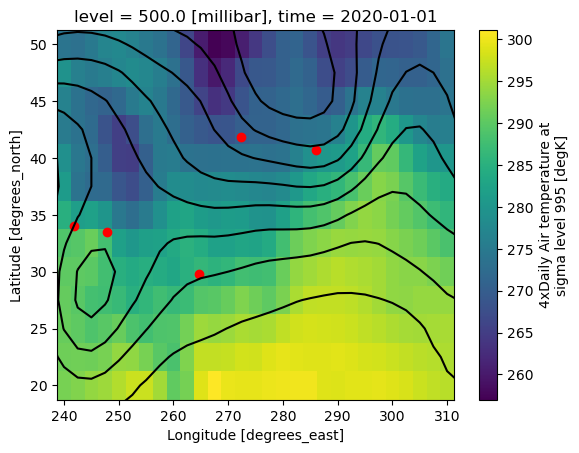

In [62]:
# Quick map plot of air temperature 'air', Z500, and site locations

Tverif.air.sel(lat = slice(50,20), lon=slice(360-120,360-50)).plot()
Z.hgt.sel(level=500).plot.contour(colors='k', levels=20)
plt.scatter(sitelons, sitelats, c='red')

In [64]:
Tverif.sel(lon = sitelons, lat = sitelats, method='nearest').to_dataframe()

,lat,lon,time,air
dim_0,,,,
0,40.0,285.0,2020-01-01,278.899994
1,35.0,242.5,2020-01-01,281.500000
2,42.5,272.5,2020-01-01,270.100006
3,30.0,265.0,2020-01-01,286.200012
4,32.5,247.5,2020-01-01,287.899994


## Downscaling model grid to site-scale verification

Placeholder: just add random noise. How much noise? 

Placeholder: specified magnitude
Next better: the difference between interpolated and nearest-gridpoint values. 

In [83]:
# Extract temperature values at site locations and add 'downscaling' noise for site values

T_grids = Tverif.sel(lon = sitelons, lat = sitelats, method='nearest')
sw_grids = soilw.sel(lon = sitelons, lat = sitelats, method='nearest')

Tnoise = np.random.random( sitelons.size )-0.5   # random on [0,1] - 0.5

## Cost-benefit score based on verification
### adjusted for preparations made the basis of forecasts 

"weather" here is mapped onto anomalous T (Tsa_sites) and moisture (Manom) space, where a costfunction is defined. All extremes are costly, but optimim is perhaps a bit warmer than climatology, for instance if this is midlatitude agriculture. Of course this varies by business application, and keeps the game fresh when different businesses are considered. 

In [85]:
def value_of_preparations(preps):
    return 0    # constant, or array the same shape as costfunction

In [ ]:
costfunction = xr.open_dataset('../BiznessSpecificParameters/costfunction.nc')     # business-specific valuation of wx outcome
insfactor = xr.open_dataset('../BiznessSpecificParameters/insurancefactor.nc')  # factor <1 on negative parts of costfunction 

# weather praparations 'preps' is where Forecast data have been used...
preps = pd.open('TEAMDATA/mypreps.csv')    # contains insurancecost, R&D, asset/personnel deployments, ...


score = (costfunction[TSA_sites, Manom_sites] \    # sample costfunction at set of sites 
         - value_of_preparations(preps)     ) \    # subtract offset for preparations 
         * insfactor *preps.insurancecost )        # the more insurance bought, the stronger the factor      

totalscore = np.sum(score) - preps.insurancecost   # insurancefactor.nc has cost